## 1 Working with Extracellular Spike Data

The goal of this assignment is for you to learn how extracellular neural recordings are analyzed. You will be looking at recordings obtained from the songbird auditory cortex while recordings of bird songs were played to the animals.

![experiment diagram](images/experiment_diagram.png "Auditory Neurophysiology Experiment")

This web page is a Python notebook. It's a interactive document that lets you mix text and computer code, organized into `cells`. A cell can contain either text or code. This is a text cell. You can edit the contents of this cell by double-clicking, then save by typing `Ctrl-Enter`.

**Your Assignment**: Turn in a written response to each of the questions (e.g. **Q1**) below.

The cell below this is a code cell, as indicated by `In [ ]:` off to the left. When you type `Ctrl-Enter` in a code cell, the contents are passed to the Python interpreter. Each line is evaluated in turn. If the last line generates some output, this will be shown below the code cell. To run the notebook, you need to type `Ctrl-Enter` in each cell (including the one below):

In [1]:
# These lines of code import some external libraries we'll use in this exercise. Hit Ctrl-Enter to execute.
%matplotlib notebook
from tools import signal
import numpy as np
import IPython
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.cmap'] = 'jet'
mpl.rcParams['figure.figsize'] = (15.0, 4.0)

### Auditory responses

The basic structure of an auditory neurophysiology experiment is that we play a stimulus to the animal while recording from one or more neurons (or *units*) in the brain. The neurons are usually presented with a range of different stimuli to probe how selective they are or determine what parts of the stimulus excite them the best.

Let's look at the response of a neuron to a stimulus:

<IPython.core.display.Javascript object>


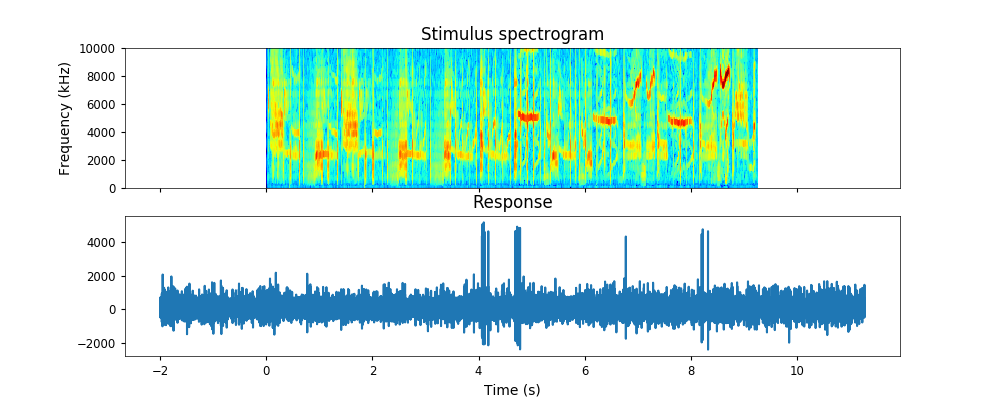

In [14]:
%matplotlib notebook
stim_name = "A8"
stim, sampling_rate = signal.load_stimulus(stim_name)
spec, freq, bins = signal.specgram(stim, sampling_rate)
r, t = signal.load_raw_responses("st11_1_2", stim_name)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
axes[0].imshow(spec, extent=(bins[0], bins[-1], freq[0], freq[-1]))
axes[0].set_ylabel("Frequency (kHz)")
axes[0].set_title("Stimulus spectrogram")
axes[1].plot(t, r[0])
axes[1].set_xlabel("Time (s)")
axes[1].set_title("Response");

The plot generated above is *interactive*. Click the icon that looks like a square, and you can zoom in on different regions of the top or bottom graph. To restore the original view, click the icon that looks like a house.

The top plot is a **spectrogram** of the stimulus. Spectrograms show the power in the sound as a function of time and frequency. More intense colors indicate more power. You can read the plot like a musical score.

The bottom plot shows the neural recording. The recording begins before the stimulus starts and continues after it ends. These parts of the response are called the **background** or **spontaneous activity**. The part of the response that's aligned with the stimulus is called the **evoked response**.

**Q1**

1. Most of the recording is low-amplitude **noise**. Zoom in on a section of the response around 0 s. Describe what this looks like up close.
3. This neuron responded with brief bursts of **action potentials**, which caused high-amplitude **spikes** in the signal around 4 s. Zoom in on these and describe what the spikes look like.
4. Zoom back out a little and see if you can spot some patterns in the spectrogram that preceded the spiking. Do these data suggest that the neuron is responding to a particular kind of sound?

---
There are many sources of variability in the brain, so not every spike in a given trial is necessarily caused by the stimulus. Thus, each stimulus is usually presented 5-20 times to get an average that represents the part of the response that's driven by the stimulus. Let's look at a few responses to the same stimulus:

<IPython.core.display.Javascript object>


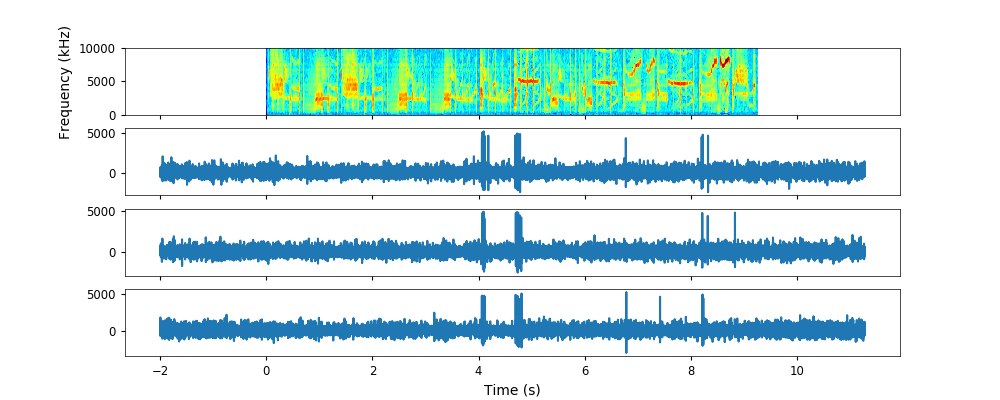

Text(0.5,0,'Time (s)')

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 4), sharex=True)
axes[0].imshow(spec, extent=(bins[0], bins[-1], freq[0], freq[-1]))
axes[0].set_ylabel("Frequency (kHz)")
axes[1].plot(t, r[0])
axes[2].plot(t, r[1])
axes[3].plot(t, r[2])
axes[3].set_xlabel("Time (s)")

**Q2:** Zoom in on the spike bursts and compare the responses across the trials. What are the differences? What stays the same?

### Spike sorting

A key first step in analyzing the results of an experiment is to *sort spikes*. This is a process that takes the raw neural recordings, which are densely sampled time series, and extracts the times when a spike ocurred. To be able to say that a set of spikes represents a single neuron, we need to make sure that the waveforms are distinct from the noise. There are many different methods of doing *spike sorting*, but the major steps usually consist of:

1. filter the recording to emphasize fast transients (spikes)
1. identify potential spikes and extract their waveforms
2. cluster similar waveforms together and exclude noise and artifacts

![spike sorting diagram](images/spike_sorting_diagram.png)

Let's start with spike detection. What we need to do is determine when the signal crosses above a threshold. Setting the threshold is usually done manually. The following code snippet will illustrate how this is done.

<IPython.core.display.Javascript object>


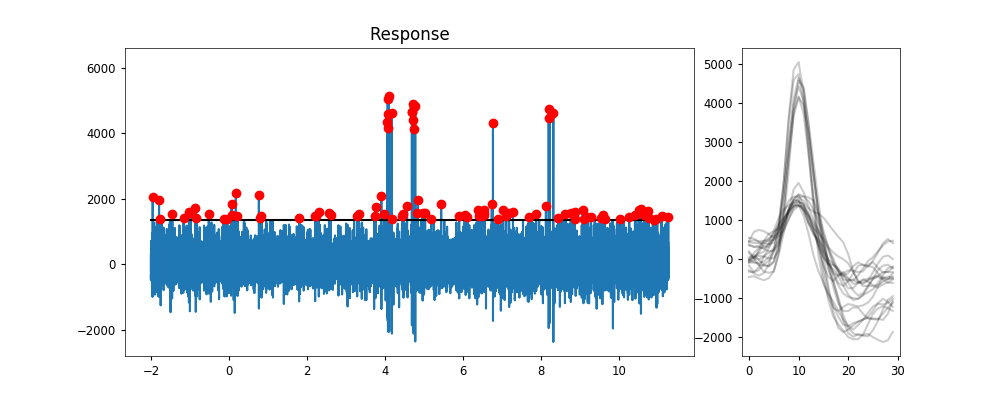

FloatSlider(value=6182.4, continuous_update=False, description='Threshold:', max=6182.4, step=61.824)

In [117]:
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot2grid((1,4),(0,0),colspan=3)
ax1.set_title("Response")
ax2 = plt.subplot2grid((1,4),(0,3))
ax2.set_title("Spikes")
fig.subplots_adjust(wspace=0.3)

# change unit name and stimulus to try with other data
r, t = signal.load_raw_responses("st11_1_2", "A8")
graphics.spike_detector(ax1, ax2, r[0], t)

Move the `Threshold` slider to adjust the position of the black line. Any events that cross this line will be detected. A subset of the detected events will be plotted in the right panel as you adjust the threshold, and you can see the detected events marked with a red dot.

**Q3:** Try adjusting the threshold so that all of the detected events have similar waveforms. How many spikes were evoked by the stimulus? What happens if you set the threshold too low?

---
We're now going to cluster the spikes. The method we'll use is based on **principal components analysis**, which converts each waveform into a set of three numbers that describe its shape. In spike sorting, you're going to select a cluster of waveforms that correspond to the spikes. There are other waveforms that correspond to noise.

Switch to the `klusters` window. Your instructor has already opened up the data corresponding to the `st11_1_2` unit. 

*image*

Draw a polygon around one of the clusters, then select it and look at the waveforms. Try drawing a polygon around the other cluster and look at its waveforms. Which one corresponds to the spikes?

**Q4:** Each waveform has three principal components and one additional variable that corresponds to time. Which dimension looks like it relates to time?

---
Now we're going to make sure this group of spikes corresponds to a **single unit**. To make sure that there are only a few (if any) **refractory period violations**, we're going to look at the **autocorrelation plot** (highlighted). This is a histogram of all the intervals between spike times. If the unit is well isolated, you should see a deep trough in the center, ideally with all the bins near the center having zero spikes. Compare this to the autocorrelogram for the noise cluster.

**Q5:** Why does the noise cluster have refractory period violations?

---
Save your work and open up another unit from the list below. Sort the spikes. Show your work to an instructor, then proceed to sort the rest of the list.

*list*

**Q6:** Two of the recordings captured two or more units. Which ones? How are the two units different from each other?

---
### Visualizing spike time data

We're going to skip one step in the process, which is to take the sorted spikes and write the spike times to a file. This has already been done, so you can now open up the resulting file and plot the spike time data as a **raster plot**. Run the code snippet below:

In [ ]:
from tools import pprox
unit = "st11_1_2_x"
stim = "A8"
resp = pprox.load(unit)
# select only the responses to A8
resp_A8 = pprox.select_stimulus(resp, stim)

# plot here

**Q7:** How does this plot compare to what you saw in the raw recordings? What's the advantage of visualizing the response this way?

---
Now let's look at the response to several different stimuli.

In [ ]:
# this statement will give you a large canvas on which to put all your subplots
mpl.rcParams['figure.figsize'] = (15.0, 20.0)
# insert your code here. Good luck!

**Q8:** Zoom in to the parts of the spectrogram that evoked strong responses. Do you see any patterns?

---
Pick one of the units from this list. Paste it into the code snippet below, between the quotes on the line that starts with `unit =`.

**Q9:** How does the response of this unit compare to `st11_1_2`?